In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
names = open("../names.txt", "r").read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# count the number of letters and prepare the index
letters = set()
for name in names:
    for c in name:
        letters.add(c)

letter_list = list(letters)
letter_list.append(".")
letter_list.sort()

stoi = {s:i for i, s in enumerate(letter_list)}
itos = {i:s for s, i in stoi.items()}

In [5]:
def prep_data(names, block_size):
    x, y = [], []
    for name in names:
    # add the necessary padding to the name
        modified_string = block_size * "." + name + "."
        for ch1, ch2, ch3, ch4 in zip(modified_string, modified_string[1:], modified_string[2:], modified_string[3:]):
            x.append([stoi[ch1], stoi[ch2], stoi[ch3]])
            y.append(stoi[ch4])

    X = torch.tensor(x)
    Y = torch.tensor(y)

    return X, Y

# The data will be split as such - 80% training, 10% dev, 10% test
BLOCK_SIZE = 3

import random
random.seed(42)
random.shuffle(names)

sample_size = len(names)
train_size = int(0.8 * sample_size)
dev_size = int(0.9 * sample_size)

print(train_size, dev_size)

Xtr, Ytr = prep_data(names[:train_size], BLOCK_SIZE)
Xdev, Ydev = prep_data(names[train_size:dev_size], BLOCK_SIZE)
Xtest, Ytest = prep_data(names[dev_size:], BLOCK_SIZE)

print(Xtr.shape, Xdev.shape, Xtest.shape)

25626 28829
torch.Size([182625, 3]) torch.Size([22655, 3]) torch.Size([22866, 3])


- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that:
 1) the network trains just fine 
 2) the network doesn't train at all, but actually it is 
 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [29]:
# torchify the code

class Linear:
    def __init__(self, fan_in, fan_out, gain=1, bias=True):
        # self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
        self.weight = torch.zeros((fan_in, fan_out))
        # seems like the biases should be torch.zeros?
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, input):
        self.out = input @ self.weight
        if self.bias != None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias != None else [])

    def shape(self):
        return self.weight.shape, self.bias.shape if self.bias != None else None

class Tanh:    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class BatchNorm1d:
    def __init__(self, input_size, epsilon=1e-5, momentum=0.1):
        self.epsilon = epsilon
        self.momentum = momentum
        # initialise the running mean and running var
        self.training = True
       
        self.gamma = torch.ones(input_size)
        self.beta = torch.zeros(input_size)

        # for a normal distribution, the mean is 0 and the variance is 1
        self.running_mean = torch.zeros(input_size)
        self.running_var = torch.ones(input_size)

    # normalize the values
    def __call__(self, batch):
        # # when dim=0, the output will be (100, 100) -> (100) -> this means that there is one average for each column=
        # you only have to calculate the batch mean if you wanna update it
        if self.training:
            mean = batch.mean(0)
            var = batch.var(0)

        else:
            mean = self.running_mean
            var = self.running_var
            
        normalized = (batch - mean)/torch.sqrt(var + self.epsilon)
        self.out = normalized * self.gamma + self.beta
        
        # update the running values if training
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + mean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + var * self.momentum

        return self.out

    def parameters(self):
        return [self.gamma] + [self.beta]


In [50]:
# hyperperameters are gonna be set here
EMBEDDING_DIMENSION = 10
HIDDEN_LAYER_SIZE = 100
VOCAB_SIZE = 27

g = torch.Generator().manual_seed(2147483647) # for reproducibility
enc = torch.randn((VOCAB_SIZE, EMBEDDING_DIMENSION), generator=g)


layers = [
    Linear(EMBEDDING_DIMENSION * BLOCK_SIZE, HIDDEN_LAYER_SIZE),
    # BatchNorm1d(HIDDEN_LAYER_SIZE, momentum=0.1),
    Tanh(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE),
    # BatchNorm1d(HIDDEN_LAYER_SIZE, momentum=0.1),
    Tanh(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE),
    # BatchNorm1d(HIDDEN_LAYER_SIZE, momentum=0.1),
    Tanh(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE),
    # BatchNorm1d(HIDDEN_LAYER_SIZE, momentum=0.1),
    Tanh(),
    Linear(HIDDEN_LAYER_SIZE, VOCAB_SIZE),
    # BatchNorm1d(VOCAB_SIZE, momentum=0.1),
]

# set the last layer to be less certain, so that the initial outputs are more uniform
layers[-1].weight *= 0.1

# apply the right gain for batchnorm
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 0.7

# count the number of layers and prepare for backprop
parameters = [enc]

for layer in layers:
    parameters += layer.parameters()

sum = enc.nelement()
for p in parameters:
    sum += p.nelement()
    p.requires_grad = True

sum

36667

In [51]:
layers[3](layers[2](layers[1](layers[0](enc[Xtr[10]].view(-1, BLOCK_SIZE * EMBEDDING_DIMENSION)))))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<TanhBackward0>)

In [53]:
# once again, it is that only the bias of the last layer is being trained
layers[-1].bias.grad, layers[-1].bias

(None,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.], requires_grad=True))

In [57]:
# track the updates and the data
updates_to_data = []
# perform training
# perform a test run to check if the plotted graphs are eventually correct
for i in range(3):
    random_sample = torch.randint(0, Xtr.shape[0], (32,), generator=g)
    # create the encoding first
    output = enc[Xtr[random_sample]].view(-1, BLOCK_SIZE * EMBEDDING_DIMENSION)

    for layer in layers:
        output = layer(output)

    loss = F.cross_entropy(output, Ytr[random_sample])

    if i == 0:
        print(f"The initial loss is: {loss}")

    # for plotting
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i > 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        if not torch.equal(p.grad, torch.zeros(p.grad.shape)):
            print(f'{i}, {p.grad}')

    # what even are they tracking here man
    with torch.no_grad():
        updates_to_data.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
loss

The initial loss is: 3.2950448989868164
0, tensor([-0.0566, -0.0566,  0.0370,  0.0370,  0.0058, -0.0566,  0.0057,  0.0370,
         0.0058,  0.0058, -0.0255,  0.0058, -0.0567,  0.0371, -0.0567, -0.0255,
         0.0370,  0.0370, -0.0254,  0.0371,  0.0057,  0.0058,  0.0370,  0.0370,
         0.0370, -0.0255, -0.0255])
1, tensor([-0.0878, -0.0566,  0.0370,  0.0370,  0.0058, -0.0879,  0.0370,  0.0370,
         0.0058, -0.1192,  0.0370,  0.0058,  0.0059,  0.0058, -0.0879,  0.0370,
         0.0370,  0.0370, -0.0879,  0.0058,  0.0370,  0.0370,  0.0370,  0.0370,
         0.0370, -0.0255,  0.0370])
2, tensor([-0.0878, -0.1191,  0.0370,  0.0370, -0.0255, -0.0253,  0.0370,  0.0370,
         0.0058, -0.0566,  0.0370,  0.0058,  0.0059, -0.0567, -0.0254,  0.0370,
         0.0370,  0.0370,  0.0058,  0.0058,  0.0057, -0.0880,  0.0370,  0.0370,
         0.0370,  0.0058,  0.0370])


tensor(3.2943, grad_fn=<NllLossBackward0>)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<TanhBackward0>)
layer 1 : mean +0.00, std 0.00, saturated: 0.00%
tensor([-5.0000e-01, -4.9000e-01, -4.8000e-01, -4.7000e-01, -4.6000e-01,
        -4.5000e-01, -4.4000e-01, -4.3000e-01, -4.2000e-01, -4.1000e-01,
        -4.0000e-01, -3.9000e-01, -3.8000e-01, -3.7000e-01, -3.6000e-01,
        -3.5000e-01, -3.4000e-01, -3.3000e-01, -3.2000e-01, -3.1000e-01,
        -3.0000e-01, -2.9000e-01, -2.8000e-01, -2.7000e-01, -2.6000e-01,
        -2.5000e-01, -2.4000e-01, -2.3000e-01, -2.2000e-01, -2.1000e-01,
        -2.0000e-01, -1.9000e-01, -1.8000e-01, -1.7000e-01, -1.6000e-01,
        -1.5000e-01, -1.4000e-01, -1.3000e-01, -1.2000e-01, -1.1000e-01,
        -1.0000e-01, -9.0000e-02, -8.0000e-02, -7.0000e-02, -6.0000e-02,
        -5.0000

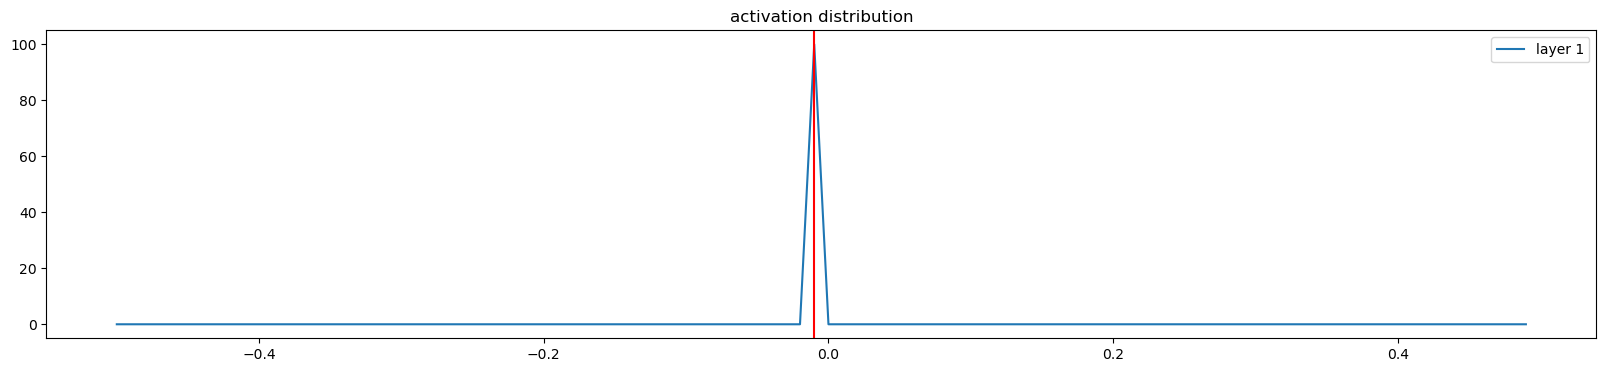

In [40]:
# visualise activations of tanh
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:2]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(t)
        print('layer %d : mean %+.2f, std %.2f, saturated: %.2f%%' % (i, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        print(hx)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i}')
plt.legend(legends);
plt.title('activation distribution')
plt.axvline(x=-0.01, color='red')

In [41]:
# It seems as if the graph looks the same for all the layers, and choosing to plot all of them will cause them to overlap exactly

a = torch.zeros((1, 30))
hy, hx = torch.histogram(a)
hy[49], hx[49] # (tensor(30.), tensor(-0.0100))

# graph ends up being non-zero because of the way that the bin values are arranged in torch.histogram

(tensor(30.), tensor(-0.0100))

layer 1 (      Tanh): mean +0.000000, std 0.000000e+00
layer 3 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 7 (      Tanh): mean +0.000000, std 0.000000e+00


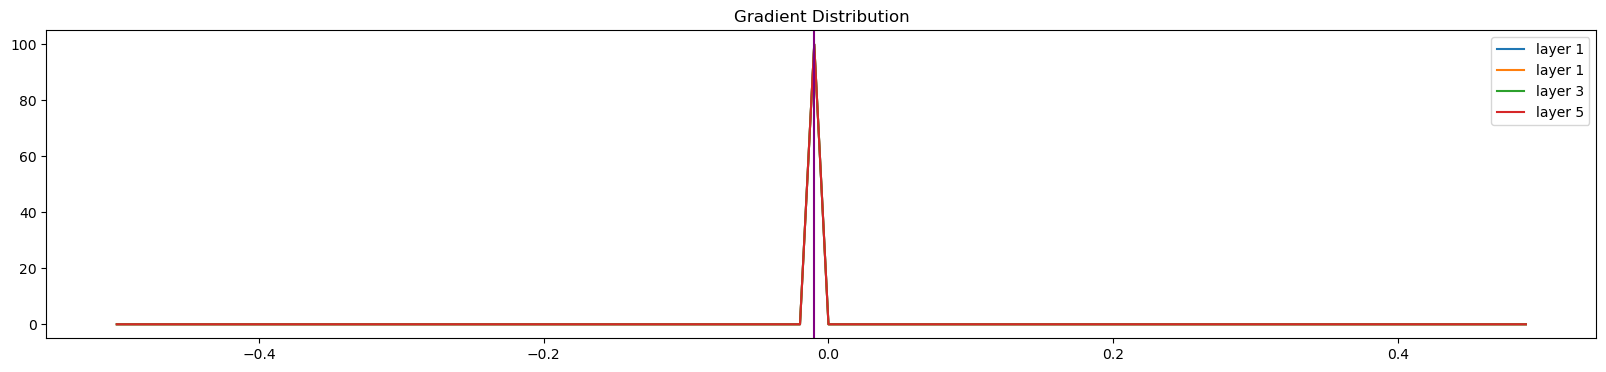

In [43]:
# visualise the gradients - they should have a somewhat normal distribution -> I think that there might be something wrong with this graph, it should not be constantly increasing help
plt.figure(figsize=(20,4))
legend = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        # hy is a representation of how frequenty they occur, while hx are the bins
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i}')

plt.legend(legends)
plt.title("Gradient Distribution")
# same in the case as above, the gradients should actually be 0
plt.axvline(x=-0.01, color='purple')

[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -in

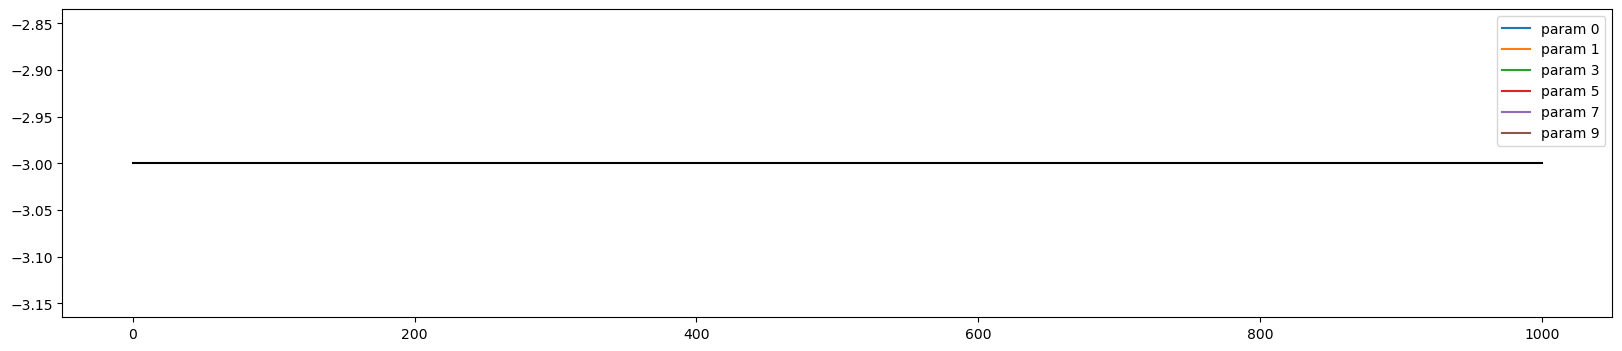

In [21]:
# collect an update to data ratio
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    # plot only the 2 dimensional nodes
    if p.ndim == 2:
        # this is basically tracking the layer across the list of parameters
        print([updates_to_data[j][i] for j in range(len(updates_to_data))])
        plt.plot([updates_to_data[j][i] for j in range(len(updates_to_data))])
        legends.append('param %d' % i)
plt.plot([0, len(updates_to_data)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [44]:
print(updates_to_data)
# in this case, all the updates are either -inf or nan because you cannot divide by 0, which are the gradients
# -inf because you are trying to take the log of 0
# nan because you are trying to divbide by 0
# in the last examples, there is some sort of value because the biases of the last layer are actually learning

[[-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0],
 [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.2533571422100067],
 [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.418661504983902]]

In [62]:
def calculate_loss(X, Y):
    with torch.no_grad():
        for layer in layers:
            if isinstance(layer, BatchNorm1d):
                layer.training = False
            
        xout = enc[X].view(-1, EMBEDDING_DIMENSION*BLOCK_SIZE)
        for layer in layers:
            xout = layer(xout)

        loss = F.cross_entropy(xout, Y)

    return loss.item()
calculate_loss(Xtr, Ytr)

3.2915380001068115

It is for sure that the only part of the network being trained are the biases. 

My hypothesis is that since biases are introduced in a + / - operation, their gradient, wrt to the loss is 1 * grad of loss function.
Since the first layer's biases are not influenced by the zeroing of the weights / biases before it, it is able to adjust them, by learning from the gradient of the loss fucntion